<a href="https://colab.research.google.com/github/Alemisa/Machine-Learning_Practical-Sessions/blob/main/Lab06_DecisionTree%2BRandom_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step-1: `Import labraries`

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

Step-2: `Load Dataset`

In [4]:
dss=pd.read_csv("healthcare.csv")

In [5]:
# Convert date columns
dss["Date of Admission"] = pd.to_datetime(dss["Date of Admission"], errors='coerce')
dss["Discharge Date"] = pd.to_datetime(dss["Discharge Date"], errors='coerce')

# Feature engineering from dates
dss["Admission_Year"] = dss["Date of Admission"].dt.year
dss["Admission_Month"] = dss["Date of Admission"].dt.month
dss["Admission_Day"] = dss["Date of Admission"].dt.day
dss["Length_of_Stay"] = (dss["Discharge Date"] - dss["Date of Admission"]).dt.days

In [6]:
# Drop identifier columns
dss = dss.drop(columns=["Name", "Date of Admission", "Discharge Date"])

In [7]:
# Features and target
target = "Test Results"
features = [
    "Age", "Gender", "Blood Type", "Medical Condition",
    "Doctor", "Hospital", "Insurance Provider",
    "Billing Amount", "Room Number", "Admission Type", "Medication",
    "Admission_Year", "Admission_Month", "Admission_Day",
    "Length_of_Stay"
]
X = dss[features]
y = dss[target]

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

2. `Preprocessing`

In [10]:
numeric_features = ["Age", "Billing Amount", "Room Number",
                    "Admission_Year", "Admission_Month",
                    "Admission_Day", "Length_of_Stay"]

categorical_features = [
    "Gender", "Blood Type", "Medical Condition", "Doctor",
    "Hospital", "Insurance Provider", "Admission Type", "Medication"
]
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

3. `Train a Decision Tree`

In [11]:
dt_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

dt_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Room Number',
                                                   'Admission_Year',
                                                   'Admission_Month',
                                                   'Admission_Day',
                                                   'Length_of_Stay']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Blood Type',
                                                   'Medical Condition',
                                                   'Doctor', 'Hospital',
                                                   'Insurance Provider',
                                                   'Admission Type',
                                                   'Medication'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [12]:
# Generate decision tree predictions as new feature
X_train_dt_pred = dt_model.predict(X_train)
X_test_dt_pred = dt_model.predict(X_test)

In [13]:
# Add DT predictions as a new categorical feature
X_train_aug = X_train.copy()
X_train_aug["DT_Prediction"] = X_train_dt_pred

X_test_aug = X_test.copy()
X_test_aug["DT_Prediction"] = X_test_dt_pred


4. `Preprocessing including DT_Prediction`

In [14]:
categorical_features_aug = categorical_features + ["DT_Prediction"]

preprocessor_aug = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_aug)
    ]
)

5. `Train Random Forest on augmented data`

In [15]:
rf_model = Pipeline([
    ("preprocessor", preprocessor_aug),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

rf_model.fit(X_train_aug, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Room Number',
                                                   'Admission_Year',
                                                   'Admission_Month',
                                                   'Admission_Day',
                                                   'Length_of_Stay']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Blood Type',
                                                   'Medical Condition',
                                                   'Doctor', 'Hospital',
                                                   'Insurance Provider',
                                                   'Admission Type',
                                                   'Medication',
                                                   'DT_Prediction'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

6. `Evaluate Random Forest`

In [16]:
y_pred = rf_model.predict(X_test_aug)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)
print("\n--- Random Forest with DT feature ---")
print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


--- Random Forest with DT feature ---
Accuracy: 0.27
Precision (macro): 0.2699556516062223
Recall (macro): 0.26886446886446885
F1-score (macro): 0.26937265632917806

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.32      0.31      0.32        70
Inconclusive       0.19      0.20      0.20        65
      Normal       0.29      0.29      0.29        65

    accuracy                           0.27       200
   macro avg       0.27      0.27      0.27       200
weighted avg       0.27      0.27      0.27       200



7. `Plot Confusion Matrix`

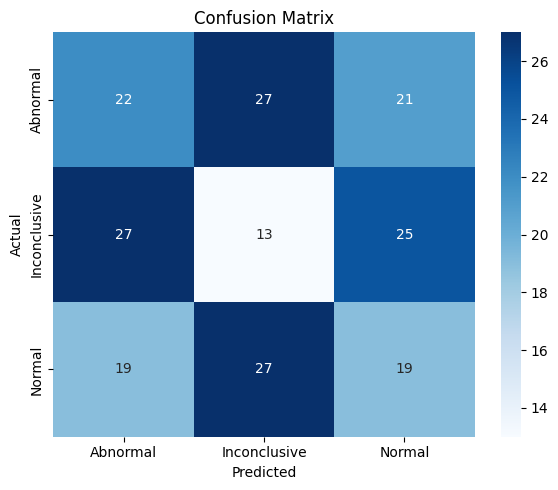

In [17]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

8. `Feature Importances`


Top 10 Feature Importances:
                         Feature  Importance
1623        DT_Prediction_Normal    0.203678
1621      DT_Prediction_Abnormal    0.201418
1622  DT_Prediction_Inconclusive    0.198776
1                 Billing Amount    0.020109
0                            Age    0.019812
2                    Room Number    0.019248
6                 Length_of_Stay    0.017658
5                  Admission_Day    0.017439
4                Admission_Month    0.015055
3                 Admission_Year    0.011713


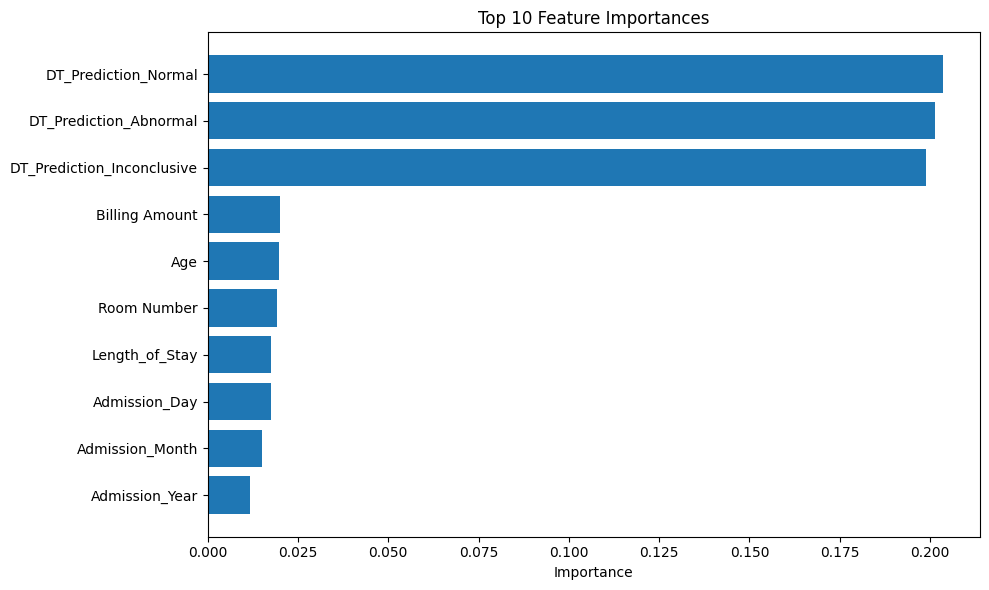

In [18]:
cat = rf_model.named_steps['preprocessor'].named_transformers_['cat']
cat_names = cat.get_feature_names_out(categorical_features_aug)
feature_names = numeric_features + list(cat_names)
importances = rf_model.named_steps['classifier'].feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feat_imp.head(10))

plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'].head(10)[::-1], feat_imp['Importance'].head(10)[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

 9. `Multiclass ROC Curve (OvR)`

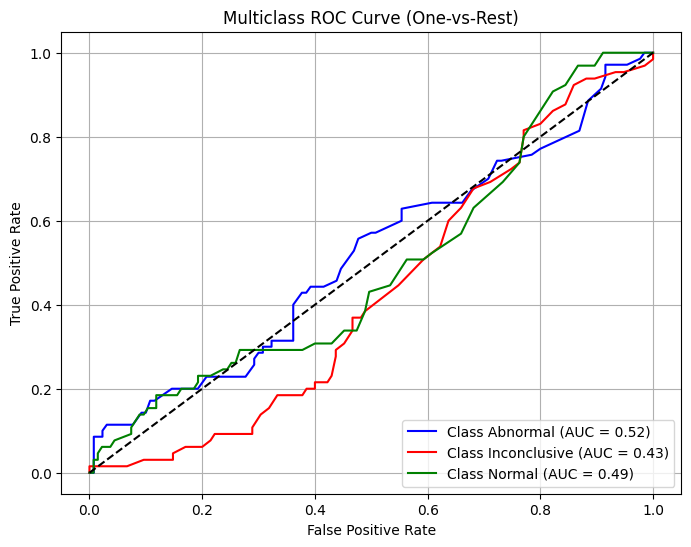

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Convert labels into one-hot format
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities for each class
y_score = rf_model.predict_proba(X_test_aug)

plt.figure(figsize=(8, 6))

# Colors for each class
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

# Plot ROC curve for each class
for i, (class_label, color) in enumerate(zip(classes, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color,
             label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Plot random-guess line
plt.plot([0, 1], [0, 1], 'k--')

# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()